In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
from itertools import combinations
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pprint import pprint
from pingouin import partial_corr
from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.iolib import SimpleTable
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import het_breuschpagan, het_goldfeldquandt, het_white, het_arch, acorr_ljungbox
from statistics import *
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from scipy.optimize import curve_fit
from scipy.stats.stats import kurtosis, skew
from scipy.stats import boxcox
from IPython.core.display import display
from patsy import dmatrices
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from arch.univariate import ARX, ARCH, GARCH
import warnings
from datetime import datetime, timedelta
import seaborn as sns
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams["axes.labelsize"] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linewidth'] = .5
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['legend.fontsize'] = 15

factors_dir = os.path.join('data', 'factors')

def read_csv(*args, **kwargs):
    kwargs.setdefault('parse_dates', ['Date'])
    kwargs.setdefault('index_col', 'Date')
    res = pd.read_csv(*args, **kwargs)
    if res.size < 50:
        res = res.resample('1y').last()
    elif res.size < 600:
        res = res.resample('1m').last()
    else:
        res = res.append(res.resample('1m').last())
    return res

def investing_com_convert_csv(path):
    df = pd.read_csv(path, dayfirst=True, parse_dates=['Дата'], thousands='.', decimal=',')
    df.columns = ['Date', 'Close', 'Open', 'Max', 'Min', 'Vol', 'Change']
    df = df.set_index('Date').sort_index()
    return df

In [2]:
# Индекс реального эффективного курса рубля, инвестиции в основной капитал

In [3]:
# Создание series'ов и dataframe'ов
factors_csv = os.listdir(factors_dir)
for csv_file in factors_csv:
    if csv_file.startswith('.') or not csv_file.endswith('.csv'):
        continue
    var_name = os.path.splitext(csv_file)[0].lower()
    df_name = f'{var_name}_df'
    series_name = f'{var_name}_series'
    globals()[df_name] = read_csv(os.path.join(factors_dir, csv_file))
    globals()[series_name] = globals()[df_name].Close.resample('1d').last().dropna()

In [4]:
all_df = pd.DataFrame({
    # Индекс РТС
    'RTSI': rtsi_series,
    # Индекс S&P 500
    'SP500': sp500_series,
    # FTSE - Англия
    'FTSE': ftse_series,
    # DAX - Германия
    'DAX': dax_series,
    # SSE - Китай
    'SSE': sse_series,
    # Нефть Brent
    'Brent': brent_series,
    # USD/RUB
    'USD': usd_series,
    # Темпы роста ВВП РФ
    # 'GDP': gdp_series,
    # Золото
    'Gold': gold_series,
    # Уровень безработицы в РФ
    'Unemployment': unemployment_series,
    # Индекс потребительских цен
    # 'CPI': cpi_series,
    # Индекс потребительских цен погодично
    # 'CPI_year': cpi_year_series,
    # Индекс потребительских цен относительно 2000 года
    # 'CPI2000': cpi2000_series,
    # Индекс потребительских цен относительно 1996 года
    # 'CPI1996': cpi1996_series,
    # Ставки по межбанковским кредитам
    'InterbankRate': interbank_rate_series,
    # Доходность 6 месячных облигаций США
    'USA6mBond': usa_6m_bond_series,
    # Инвестиции в основной капитал
    # 'capital_investment': capital_investment_series,
    # Внешняя торговля РФ
    'international_trade': international_trade_series,
    # Индекс производительности труда
    'labor_performance': labor_performance_series,
    # Индекс промышленного производства
    'industrial_production': industrial_production_series,
    # Ключевая ставка
    'key_rate': key_rate_series,
    # Остатки на корреспондентских счетах
    # 'correspondent_accounts': correspondent_accounts_series,
    # Остатки на корреспондентских счетах (средние скорректированные)
    'correspondent_accounts_mean_scorr': correspondent_accounts_mean_scorr_series,
    # Номинальная зарплата
    # 'nominal_salary': nominal_salary_series,
    # Скорректированная номинальная зарплата
    'nominal_salary_scorr': nominal_salary_scorr_series,
    # ВВП РФ в абсолютном значении
    # 'abs_gdp': abs_gdp_series,
    # Скорректированный ВВП РФ в абсолютном значении
    'abs_gdp_scorr': abs_gdp_scorr_series,
    # Скорректированные инвестиции в основной капитал
    'capital_investment_scorr': capital_investment_series
})

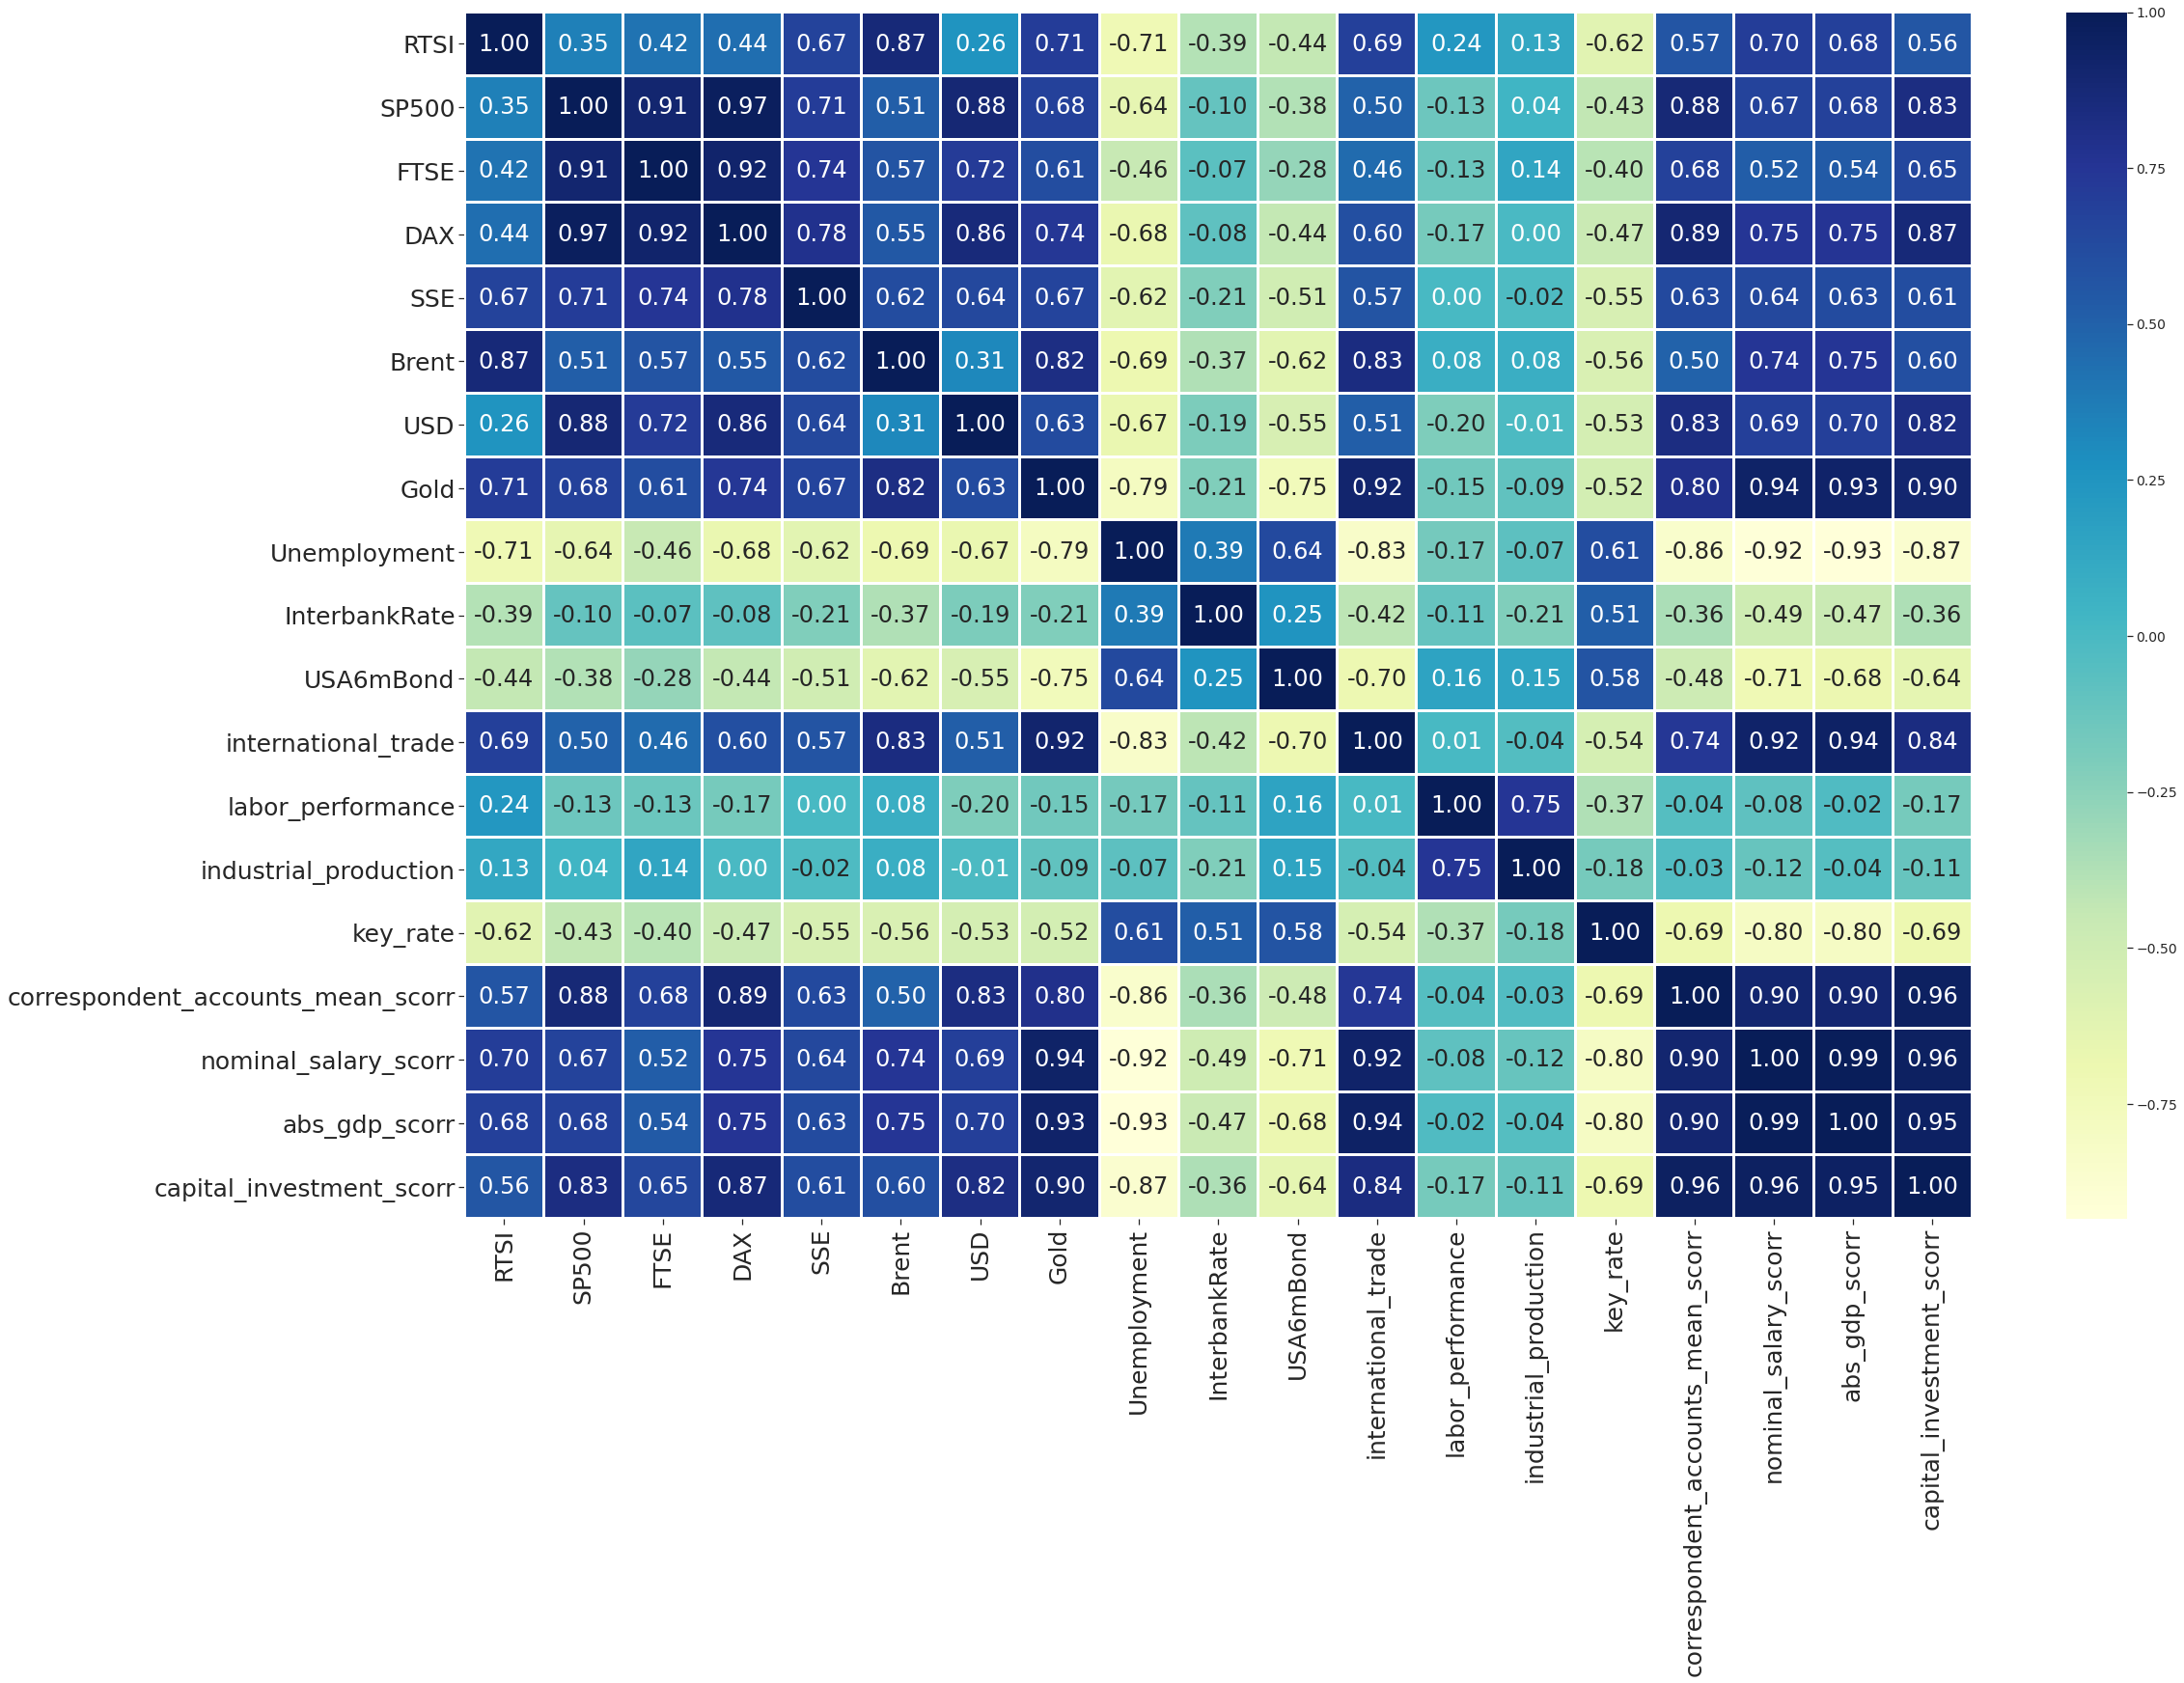

In [5]:
fig, ax = plt.subplots(figsize=(35, 23))
ax.tick_params(labelsize=25)
sns.heatmap(
    all_df.corr(), cmap='YlGnBu', annot=True, linewidths=2, 
    ax=ax, annot_kws={'size': 24},
    fmt='.2f'
);

In [6]:
# Добавить dax_sp500 и sse_sp500

In [7]:
columns = all_df.columns.drop(['RTSI'])

In [8]:
max_mc = []
# for i in range(5, len(columns)+1):
#     print(i)
#     for factors in combinations(columns, i):
#         res = np.linalg.det(all_df[list(factors)].corr())
#         if res >= .1:
#             max_mc.append((res, factors))

## Метод главных компонент

### Расчет факторных нагрузок

In [9]:
tmp = all_df[['SP500', 'SSE', 'DAX', 'FTSE']]['1996':'2019'].resample('1y').last()
tmp_centered = [tmp[col]-tmp[col].mean() for col in tmp.columns]
tmp_cov = np.cov(tmp_centered)
_, tmp_eig = np.linalg.eig(tmp_cov)
tmp_v = tmp_eig[:, 0]

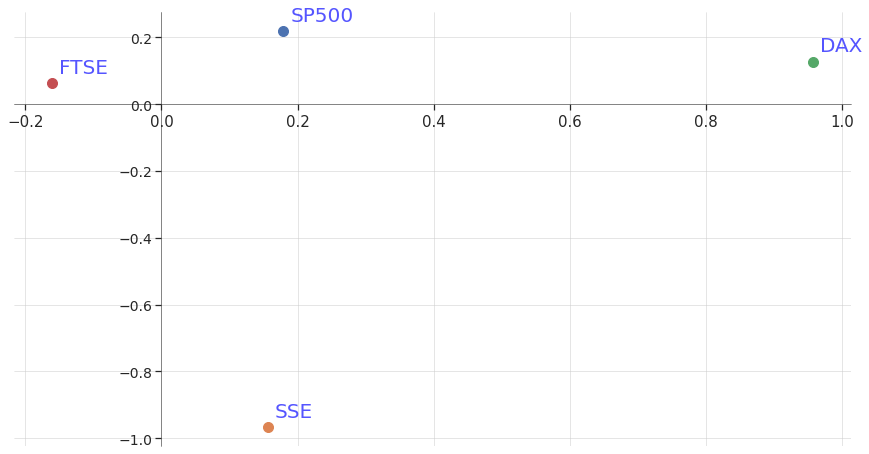

In [10]:
for x, y, name in zip(*tmp_eig[:2], tmp.columns):
    plt.scatter(x, y, s=100);
    plt.text(x+.01, y+.03, name, fontsize=20, color='#55ff')
    
ax = plt.gca()
ax.spines['left'].set_position('zero')
ax.spines['left'].set_linewidth(.5)
ax.spines['bottom'].set_position('zero')
ax.spines['bottom'].set_linewidth(.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### Расчет значений (PC)

In [11]:
pca = PCA(n_components=2)
xpca_reduced = pca.fit_transform(tmp)
print('Процент объясненной дисперсии', pca.explained_variance_ratio_)

dax_sp500 = pd.Series(xpca_reduced[:, 0], index=tmp.index)
sse_sp500 = pd.Series(xpca_reduced[:, 1], index=tmp.index)

Процент объясненной дисперсии [0.93243375 0.05045146]


### Поиск уравнения

In [12]:
test_df = all_df['1996':'2019'].resample('1y').last().copy()
for column in test_df.columns.drop('RTSI'):
    test_df[f'{column}_2'] = test_df[column] ** 2
    test_df[f'{column}_3'] = test_df[column] ** 3
    test_df[f'{column}_ln'] = np.log(test_df[column])

test_df['dax_sp500'] = dax_sp500
test_df['sse_sp500'] = sse_sp500
test_df.drop(['international_trade_3', 'capital_investment_scorr_3'], axis=1, inplace=True)

In [13]:
# 8 факторов
smf.ols(f'RTSI ~ SP500+FTSE+DAX+SSE+Brent+USD+abs_gdp_scorr+international_trade_2', data=test_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   RTSI   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     28.62
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           9.84e-08
Time:                        20:41:53   Log-Likelihood:                -154.69
No. Observations:                  24   AIC:                             327.4
Df Residuals:                      15   BIC:                             338.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -2425.3167    717.070     -3.382      0.004   -3953.715    -896.919
SP500                     0.5230      0.274      1.910      0.075      -0.061       1.107
FTSE                      0.4057      0.166      2.438      0.028       0.051       0.760
DAX                      -0.3156      0.105     -3.010      0.009      -0.539      -0.092
SSE                       0.2654      0.068      3.893      0.001       0.120       0.411
Brent                     8.4289      3.533      2.385      0.031       0.898      15.960
USD                     -15.3689      6.107     -2.517      0.024     -28.385      -2.352
abs_gdp_scorr             0.6393      0.167      3.819      0.002       0.282       0.996
international_trade_2 -2.128e-09    5.3e-10     -4.017      0.001   -3.26e-09   -9.99e-10
==============================================================================
Omnibus:                        0.094   Durbin-Watson:                   2.664
Prob(Omnibus):                  0.954   Jarque-Bera (JB):                0.266
Skew:                           0.118   Prob(JB):                        0.875
Kurtosis:                       2.541   Cond. No.                     6.88e+12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.88e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### 10 факторов (11 - sse_sp500)

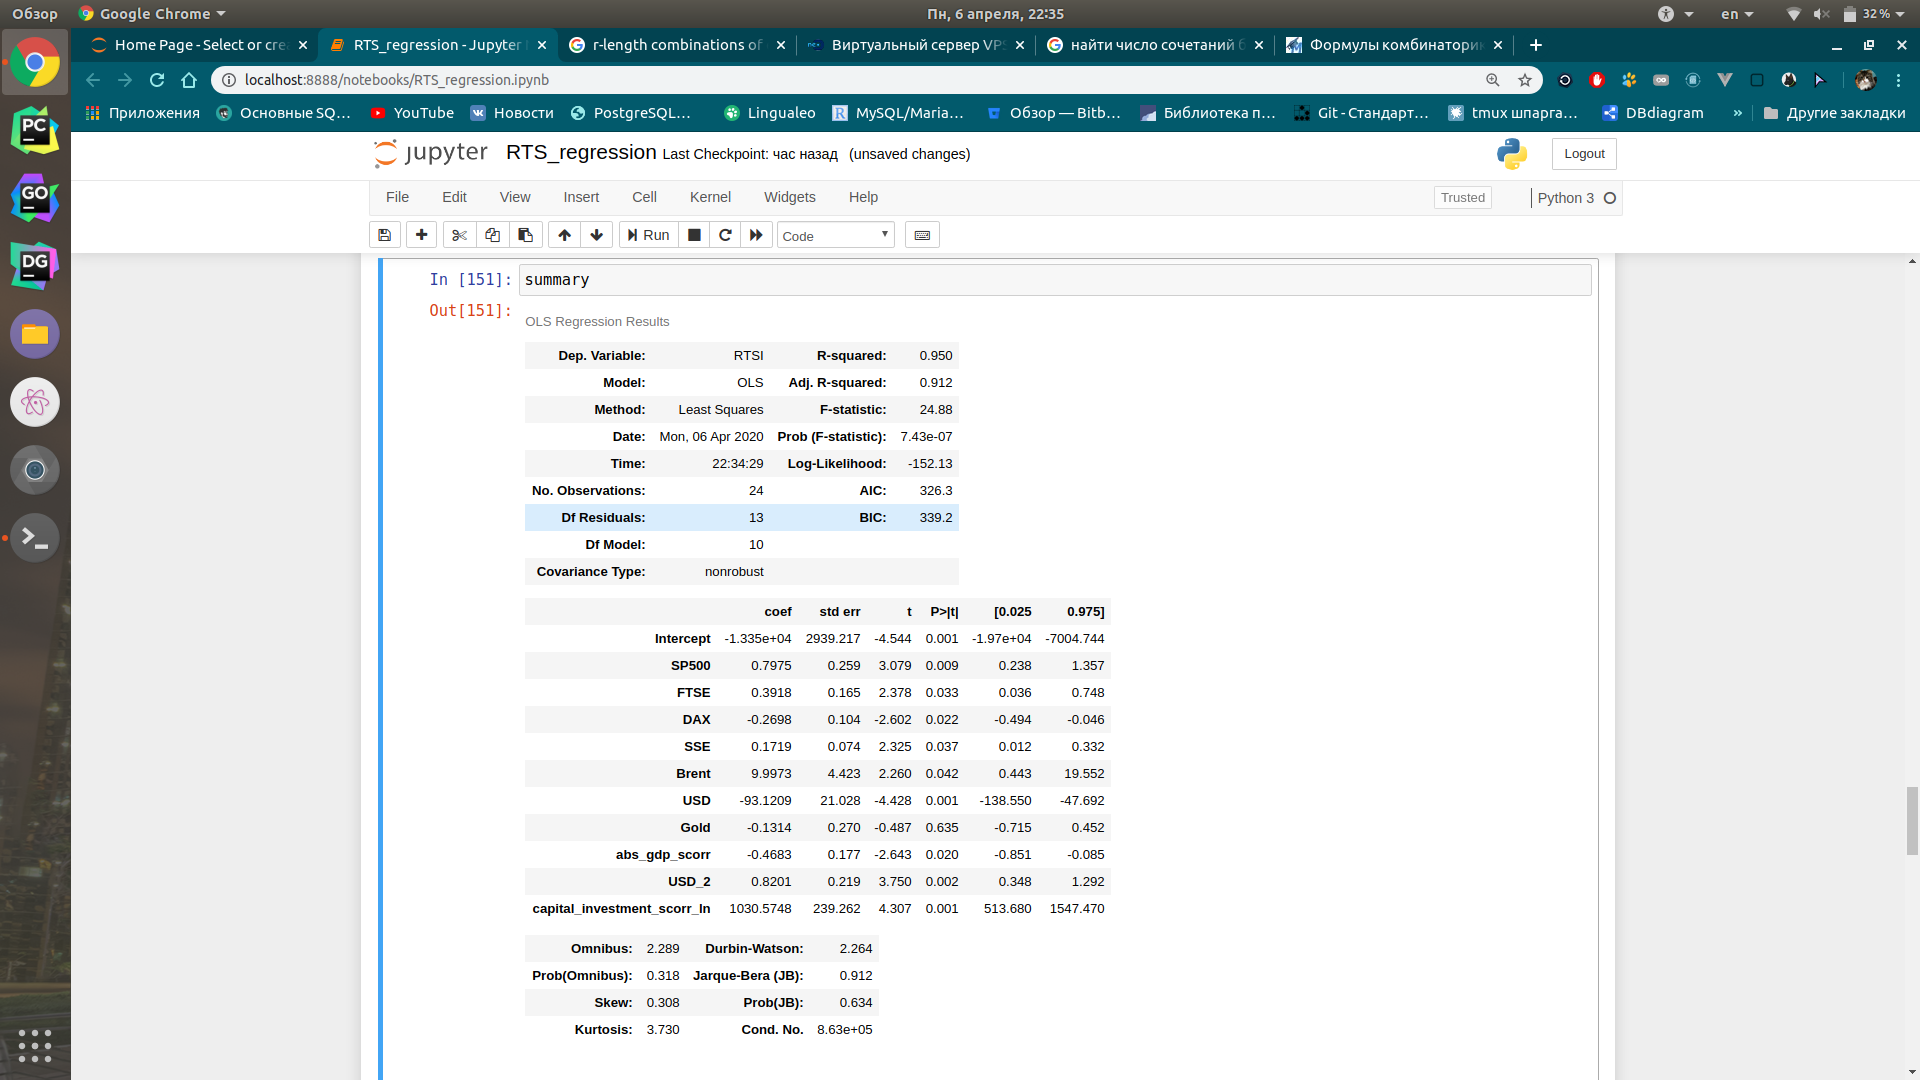

##### Функция по поиску уравнения

In [15]:
res = []
# Со скольки факторов искать
start_factor_count = 11
try:
    for i in range(start_factor_count, len(test_df.columns)-1):
        break
        for factors in combinations(test_df.columns.drop('RTSI'), i):
            fitted = smf.ols(f'RTSI ~ {"+".join(factors)}', data=test_df).fit()
            summary = fitted.summary()
            t_statistic = list(map(lambda x: float(x[3].data.strip()), summary.tables[1][2:]))
            if sum([abs(x) >= 2.2 for x in t_statistic]) >= len(factors)-1:
                r2 = float(summary.tables[0][0][3].data.strip())
                res.append((r2, factors))
        break
except KeyboardInterrupt:
    print('Спасибо')
except Exception:
    pass
res

[]

### Получившиеся уравнения из 12 факторов

In [39]:
regression1 = smf.ols(
    'RTSI ~ SP500 + FTSE + DAX + SSE + Brent + USD + Gold + InterbankRate + SP500_2 + Brent_ln + Unemployment_ln + nominal_salary_scorr_ln',
    data=test_df
).fit()
regression1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   RTSI   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     46.78
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           1.15e-07
Time:                        21:08:42   Log-Likelihood:                -140.74
No. Observations:                  24   AIC:                             307.5
Df Residuals:                      11   BIC:                             322.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                1122.6521   2643.087      0.425      0.679   -4694.742    6940.046
SP500                      -4.3147      1.038     -4.158      0.002      -6.599      -2.031
FTSE                        1.4073      0.219      6.416      0.000       0.925       1.890
DAX                        -0.3641      0.071     -5.137      0.000      -0.520      -0.208
SSE                         0.1644      0.048      3.392      0.006       0.058       0.271
Brent                      25.2291      6.391      3.948      0.002      11.163      39.295
USD                        12.1517      6.951      1.748      0.108      -3.147      27.451
Gold                       -0.5821      0.242     -2.409      0.035      -1.114      -0.050
InterbankRate             -53.0921      9.542     -5.564      0.000     -74.094     -32.090
SP500_2                     0.0008      0.000      4.485      0.001       0.000       0.001
Brent_ln                -1981.9854    430.337     -4.606      0.001   -2929.150   -1034.821
Unemployment_ln         -2401.2557    528.497     -4.544      0.001   -3564.471   -1238.041
nominal_salary_scorr_ln  1337.1632    280.301      4.770      0.001     720.226    1954.101
==============================================================================
Omnibus:                        2.529   Durbin-Watson:                   2.779
Prob(Omnibus):                  0.282   Jarque-Bera (JB):                1.201
Skew:                           0.032   Prob(JB):                        0.549
Kurtosis:                       1.906   Cond. No.                     3.77e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.77e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
smf.ols(
    'RTSI ~ SP500 + FTSE + DAX + SSE + Brent + USD + Gold + InterbankRate + SP500_3 + Brent_ln + Unemployment_ln + nominal_salary_scorr_ln',
    data=test_df
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   RTSI   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     49.05
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           8.96e-08
Time:                        20:47:36   Log-Likelihood:                -140.18
No. Observations:                  24   AIC:                             306.4
Df Residuals:                      11   BIC:                             321.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 385.1012   2529.971      0.152      0.882   -5183.327    5953.529
SP500                      -2.7318      0.673     -4.062      0.002      -4.212      -1.252
FTSE                        1.3036      0.196      6.662      0.000       0.873       1.734
DAX                        -0.3227      0.068     -4.737      0.001      -0.473      -0.173
SSE                         0.1573      0.048      3.283      0.007       0.052       0.263
Brent                      22.5621      5.867      3.845      0.003       9.648      35.476
USD                         9.5220      6.284      1.515      0.158      -4.310      23.354
Gold                       -0.5358      0.231     -2.324      0.040      -1.043      -0.028
InterbankRate             -51.2513      9.085     -5.641      0.000     -71.248     -31.255
SP500_3                  1.235e-07   2.66e-08      4.647      0.001     6.5e-08    1.82e-07
Brent_ln                -1855.8502    400.634     -4.632      0.001   -2737.640    -974.060
Unemployment_ln         -2353.9980    509.227     -4.623      0.001   -3474.799   -1233.197
nominal_salary_scorr_ln  1298.3328    270.771      4.795      0.001     702.370    1894.295
==============================================================================
Omnibus:                        0.102   Durbin-Watson:                   2.726
Prob(Omnibus):                  0.950   Jarque-Bera (JB):                0.325
Skew:                           0.025   Prob(JB):                        0.850
Kurtosis:                       2.432   Cond. No.                     9.66e+11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.66e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
smf.ols(
    'RTSI ~ SP500 + FTSE + DAX + SSE + Brent + USD + Gold + InterbankRate + SP500_ln + Brent_ln + Gold_3 + nominal_salary_scorr_ln',
    data=test_df
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   RTSI   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     21.97
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           5.99e-06
Time:                        20:48:22   Log-Likelihood:                -149.55
No. Observations:                  24   AIC:                             325.1
Df Residuals:                      11   BIC:                             340.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                5672.7499   7934.356      0.715      0.490   -1.18e+04    2.31e+04
SP500                       1.4321      0.587      2.441      0.033       0.141       2.723
FTSE                        1.1663      0.332      3.514      0.005       0.436       1.897
DAX                        -0.3550      0.108     -3.299      0.007      -0.592      -0.118
SSE                         0.2939      0.065      4.551      0.001       0.152       0.436
Brent                      23.7246     10.060      2.358      0.038       1.582      45.867
USD                        12.6905     11.725      1.082      0.302     -13.115      38.496
Gold                       -2.8254      1.035     -2.729      0.020      -5.104      -0.547
InterbankRate             -35.4613     11.680     -3.036      0.011     -61.168      -9.755
SP500_ln                -3540.9277   1586.698     -2.232      0.047   -7033.228     -48.628
Brent_ln                -1355.7094    583.767     -2.322      0.040   -2640.573     -70.846
Gold_3                   4.798e-07      2e-07      2.398      0.035    3.94e-08     9.2e-07
nominal_salary_scorr_ln  2665.9508    673.940      3.956      0.002    1182.620    4149.282
==============================================================================
Omnibus:                        0.063   Durbin-Watson:                   3.082
Prob(Omnibus):                  0.969   Jarque-Bera (JB):                0.275
Skew:                          -0.059   Prob(JB):                        0.872
Kurtosis:                       2.489   Cond. No.                     3.96e+11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.96e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
smf.ols(
    'RTSI ~ SP500 + FTSE + DAX + SSE + Brent + USD + Gold + InterbankRate + DAX_ln + Gold_2 + InterbankRate_ln + international_trade_2',
    data=test_df
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   RTSI   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     19.58
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           1.08e-05
Time:                        20:49:57   Log-Likelihood:                -150.88
No. Observations:                  24   AIC:                             327.8
Df Residuals:                      11   BIC:                             343.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -2.858e+04   8434.968     -3.388      0.006   -4.71e+04      -1e+04
SP500                     1.6856      0.408      4.133      0.002       0.788       2.583
FTSE                     -0.4513      0.242     -1.862      0.089      -0.985       0.082
DAX                      -0.6588      0.173     -3.817      0.003      -1.039      -0.279
SSE                       0.1850      0.077      2.409      0.035       0.016       0.354
Brent                    17.1121      5.405      3.166      0.009       5.216      29.008
USD                     -25.1696      7.588     -3.317      0.007     -41.870      -8.469
Gold                      3.5145      1.051      3.344      0.007       1.202       5.827
InterbankRate           -37.4683     16.207     -2.312      0.041     -73.140      -1.796
DAX_ln                 3686.6371   1143.489      3.224      0.008    1169.835    6203.439
Gold_2                   -0.0014      0.000     -3.245      0.008      -0.002      -0.000
InterbankRate_ln        419.0752    151.468      2.767      0.018      85.697     752.453
international_trade_2 -2.254e-09   6.89e-10     -3.271      0.007   -3.77e-09   -7.38e-10
==============================================================================
Omnibus:                        7.737   Durbin-Watson:                   2.903
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                5.545
Skew:                           0.975   Prob(JB):                       0.0625
Kurtosis:                       4.319   Cond. No.                     8.19e+13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.19e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Проверка предпосылок регрессионного анализа (остатков от тренда)
#### - Нулевая средняя величина
#### - Остатки подчиняются нормальному распределению
#### - Случайный характер остатков
#### - Гомоскедастичность
#### - Отсутствие автокорреляции
#### (Некоторые тесты выводятся выше при составлении тренда (Дарбин-Уотсон)

In [62]:
regression1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   RTSI   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     46.78
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           1.15e-07
Time:                        21:32:35   Log-Likelihood:                -140.74
No. Observations:                  24   AIC:                             307.5
Df Residuals:                      11   BIC:                             322.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                1122.6521   2643.087      0.425      0.679   -4694.742    6940.046
SP500                      -4.3147      1.038     -4.158      0.002      -6.599      -2.031
FTSE                        1.4073      0.219      6.416      0.000       0.925       1.890
DAX                        -0.3641      0.071     -5.137      0.000      -0.520      -0.208
SSE                         0.1644      0.048      3.392      0.006       0.058       0.271
Brent                      25.2291      6.391      3.948      0.002      11.163      39.295
USD                        12.1517      6.951      1.748      0.108      -3.147      27.451
Gold                       -0.5821      0.242     -2.409      0.035      -1.114      -0.050
InterbankRate             -53.0921      9.542     -5.564      0.000     -74.094     -32.090
SP500_2                     0.0008      0.000      4.485      0.001       0.000       0.001
Brent_ln                -1981.9854    430.337     -4.606      0.001   -2929.150   -1034.821
Unemployment_ln         -2401.2557    528.497     -4.544      0.001   -3564.471   -1238.041
nominal_salary_scorr_ln  1337.1632    280.301      4.770      0.001     720.226    1954.101
==============================================================================
Omnibus:                        2.529   Durbin-Watson:                   2.779
Prob(Omnibus):                  0.282   Jarque-Bera (JB):                1.201
Skew:                           0.032   Prob(JB):                        0.549
Kurtosis:                       1.906   Cond. No.                     3.77e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.77e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

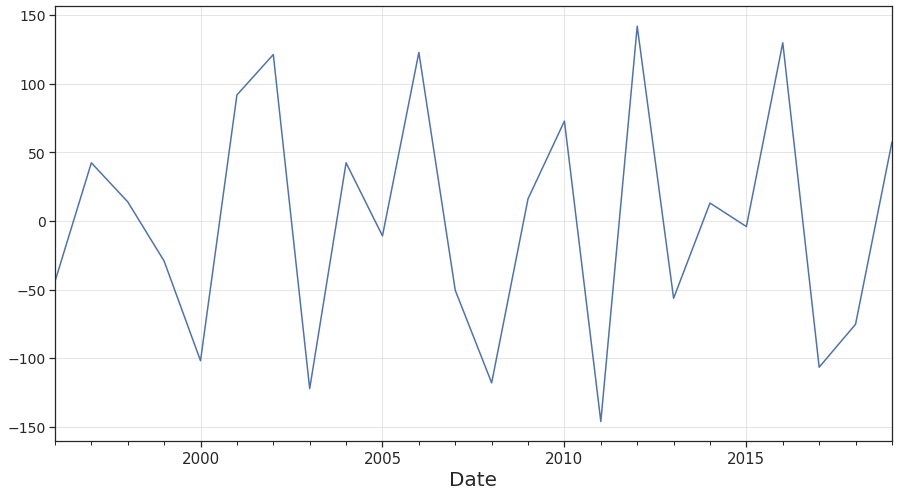

In [51]:
regression1.resid.plot();

## 1)Нулевая средняя величина 

In [42]:
print('Средняя величина остатков:', regression1.resid.mean())

Средняя величина остатков: 1.635183840183648e-10


## 2)Остатки подчиняются нормальному распределению 

### На уровне значимости 0.05, нулевая гипотеза о нормальности распределения принимается

In [44]:
display(SimpleTable(
    np.array([sm.stats.stattools.jarque_bera(regression1.resid)]),
     ['JB', 'p-value', 'skew', 'kurtosis']
))
# Гипотеза Н0 - о нормальном распределении остатков
# Чем ближе распределение ошибок к нормальному, тем меньше статистика Харке—Бера отличается от нуля.
# При достаточно большом значении статистики p-value будет мало,
# и тогда будет основание отвергнуть нулевую гипотезу (статистика попала в «хвост» распределения). 

JB,p-value,skew,kurtosis
1.2005283499277855,0.5486666729485372,0.03217854732700712,1.9062054515150115


### Критерии ассиметрии и эксцесса, и РС

In [47]:
kurt = kurtosis(regression1.resid)
n = regression1.resid.size
kurt_critical = 5*(24*n*(n-2)*(n-3)/(n+1)**2/(n+3)/(n+4))**.5
sk = skew(regression1.resid)
sk_critical = 3*(6*(n-1)/(n+1)/(n+3))**.5

if kurt < kurt_critical:
    print(f'Эксцесс {kurt:.4f} меньше критического {kurt_critical:.4f}')
else:
    print(f'Эксцесс {kurt:.4f} больше, либо равен критическому {kurt_critical:.4f}')

if sk < sk_critical:
    print(f'Ассиметрия {sk:.4f} меньше критического {sk_critical:.4f}')
else:
    print(f'Ассиметрия {sk:.4f} больше, либо равна критической {sk_critical:.4f}')
    
rem = regression1.resid
# Полученное значение сравнивается с табличными 
# С вероятностью ошибки-0.01 и длиной выборки ~30 РС критерий должен быть в диапазон(3.27; 5.26)
rc = (rem.max() - rem.min()) / ((rem**2).sum()/len(rem)-1)**.5
print(f'РС критерий: {rc:.4f}')

Эксцесс -1.0938 меньше критического 3.7523
Ассиметрия 0.0322 меньше критического 1.3565
РС критерий: 3.3808


## 3)Случайный характер остатков 

In [48]:
fuller_test = adfuller(regression1.resid)
if fuller_test[0] > fuller_test[4]['5%']:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')
del fuller_test
#H0 - наличие единичного корня т.е. нестационарность ряда
# Если p-value (второе значение теста) больше критического (0.05), то мы не можем отвергнуть нулевую гипотезу
# + проверяем значение самого теста. Если значение > критического от 5%, то ряд нестационарен.

Ряд стационарен


## 4)Гомоскедастичность

In [52]:
bp_test = het_breuschpagan(regression1.resid, regression1.model.exog)
labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]
print(dict(zip(labels, bp_test)))
# H0 - наличие гомоскедастичности. Если оба p-value меньше 0.05 - гетероскедастичность

{'LM Statistic': 10.561866475363725, 'LM-Test p-value': 0.566791908812073, 'F-Statistic': 0.7204654513962446, 'F-Test p-value': 0.7095913537632375}


In [55]:
het_goldfeldquandt(regression1.resid, regression1.model.exog, store=True)
# H0 - о равенстве дисперсий в двух подвыборках (гомоскедастичность)
# Смотрим на второе число (p-value) - p-value гипотезы что дисперсии отличаются. Если большое, то гетероскедастичность

(nan,
 nan,
 'increasing',
 <statsmodels.stats.diagnostic.ResultsStore at 0x7f095c695990>)

### Тест Уайта

### F-критическое ищется по таблице F(0.01; 13, 120) = 3.255

### 5.94 > F критическое => уравнение значимое => гетероскедастичность

### Если последнее число(значимость F) < 0.05 => гетероскедастичность

In [56]:
#1 вариант - использует дисперсии
white_test = het_white(regression1.resid, regression1.model.exog)
labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]
print(dict(zip(labels, white_test)))
# Тест аналогичен с бройшем паганом

{'LM Statistic': 24.0, 'LM-Test p-value': 0.40380844445980896, 'F-Statistic': nan, 'F-Test p-value': nan}


### Тест Уайта вручную (другой вариант теста)

### При гетероскедастичности все полученные члены будут значимы и p-value>0.05

In [18]:
tmp = series_remains.to_frame()
tmp['t'] = np.arange(tmp.size)
tmp['t2'] = tmp.t ** 2
tmp['t3'] = tmp.t ** 3
tmp['t4'] = tmp.t2 ** 2
tmp['t22'] = tmp.t2.copy()
tmp['t44'] = tmp.t4.copy()
tmp['t6'] = tmp.t3 ** 2
tmp['t8'] = tmp.t4 ** 2

tmp['a'] = tmp.t3.copy()
tmp['b'] = tmp.t4.copy()
tmp['c'] = tmp.t4 * tmp.t
tmp['d'] = tmp.t4 * tmp.t
tmp['e'] = tmp.t3 ** 2
tmp['f'] = tmp.t3 * tmp.t4
tmp['remains'] = series_remains ** 2

In [19]:
f = smf.ols('remains ~ (t + t2 + t3 + t4 + t22 + t44 + t6 + t8 + a + b + c + d + e + f)', data=tmp).fit()
display(f.summary())
del tmp

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                remains   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     2.078
Date:                Tue, 07 Apr 2020   Prob (F-statistic):             0.0683
Time:                        20:30:40   Log-Likelihood:                -3313.3
No. Observations:                 289   AIC:                             6639.
Df Residuals:                     283   BIC:                             6661.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.486e-06   3.03e-07      8.196      0.000    1.89e-06    3.08e-06
t             -0.0002   2.27e-05     -8.195      0.000      -0.000      -0.000
t2             0.0065      0.001      8.196      0.000       0.005       0.008
t3             0.2059      0.025      8.196      0.000       0.156       0.255
t4            -0.0026      0.000     -7.305      0.000      -0.003      -0.002
t22            0.0065      0.001      8.196      0.000       0.005       0.008
t44           -0.0026      0.000     -7.305      0.000      -0.003      -0.002
t6         -8.169e-08   1.33e-08     -6.141      0.000   -1.08e-07   -5.55e-08
t8         -2.011e-16   4.84e-16     -0.416      0.678   -1.15e-15    7.51e-16
a              0.2059      0.025      8.196      0.000       0.156       0.255
b             -0.0026      0.000     -7.305      0.000      -0.003      -0.002
c           2.706e-05   4.06e-06      6.662      0.000    1.91e-05    3.51e-05
d           2.706e-05   4.06e-06      6.662      0.000    1.91e-05    3.51e-05
e          -8.503e-08   1.37e-08     -6.211      0.000   -1.12e-07   -5.81e-08
f           1.902e-10   3.28e-11      5.797      0.000    1.26e-10    2.55e-10
==============================================================================
Omnibus:                       99.436   Durbin-Watson:                   0.683
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              283.974
Skew:                           1.565   Prob(JB):                     2.17e-62
Kurtosis:                       6.713   Cond. No.                     9.10e+31
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.41e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Тест парка на гомоскедастичность

### Гетероскедастичность если полученные уравнение по F-критерию значимы и значимый КФ при ln фактора

In [20]:
tmp = series.to_frame()
tmp['t'] = np.log(np.arange(1, series.size+1))
tmp['t2'] = np.log(np.arange(1, series.size+1)**2)
tmp['t3'] = np.log(np.arange(1, series.size+1)**3)
tmp['t4'] = np.log(np.arange(1, series.size+1)**4)
tmp['Close2'] = np.log(series_remains ** 2)
tmp

,Close,t,t2,t3,t4,Close2
Date,,,,,,
2009-01-11,498.20,0.000000,0.000000,0.000000,0.000000,8.221131
2009-01-25,520.91,0.693147,1.386294,2.079442,2.772589,8.834982
2009-02-08,517.22,1.098612,2.197225,3.295837,4.394449,9.736236
2009-02-22,576.39,1.386294,2.772589,4.158883,5.545177,9.460062
2009-03-08,696.93,1.609438,3.218876,4.828314,6.437752,7.056361
...,...,...,...,...,...,...
2019-12-01,1501.42,5.652489,11.304978,16.957468,22.609957,9.253702
2019-12-15,1549.40,5.655992,11.311984,16.967975,22.623967,9.983996
2019-12-29,1614.69,5.659482,11.318964,16.978447,22.637929,10.692561


In [21]:
smf.ols('Close2 ~ t', data=tmp).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Close2   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.255
Date:                Tue, 07 Apr 2020   Prob (F-statistic):              0.134
Time:                        20:30:41   Log-Likelihood:                -678.18
No. Observations:                 289   AIC:                             1360.
Df Residuals:                     287   BIC:                             1368.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.5326      0.741     12.872      0.000       8.075      10.990
t             -0.2328      0.155     -1.502      0.134      -0.538       0.072
==============================================================================
Omnibus:                      152.102   Durbin-Watson:                   1.079
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              846.925
Skew:                          -2.161   Prob(JB):                    1.24e-184
Kurtosis:                      10.187   Cond. No.                         24.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
smf.ols('Close2 ~ t2', data=tmp).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Close2   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.255
Date:                Tue, 07 Apr 2020   Prob (F-statistic):              0.134
Time:                        20:30:41   Log-Likelihood:                -678.18
No. Observations:                 289   AIC:                             1360.
Df Residuals:                     287   BIC:                             1368.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.5326      0.741     12.872      0.000       8.075      10.990
t2            -0.1164      0.078     -1.502      0.134      -0.269       0.036
==============================================================================
Omnibus:                      152.102   Durbin-Watson:                   1.079
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              846.925
Skew:                          -2.161   Prob(JB):                    1.24e-184
Kurtosis:                      10.187   Cond. No.                         47.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
smf.ols('Close2 ~ t3', data=tmp).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Close2   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.255
Date:                Tue, 07 Apr 2020   Prob (F-statistic):              0.134
Time:                        20:30:41   Log-Likelihood:                -678.18
No. Observations:                 289   AIC:                             1360.
Df Residuals:                     287   BIC:                             1368.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.5326      0.741     12.872      0.000       8.075      10.990
t3            -0.0776      0.052     -1.502      0.134      -0.179       0.024
==============================================================================
Omnibus:                      152.102   Durbin-Watson:                   1.079
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              846.925
Skew:                          -2.161   Prob(JB):                    1.24e-184
Kurtosis:                      10.187   Cond. No.                         71.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 5)Проверка автокорр.

### Сравниваем эту T-статистику КФ автокорр. с T-табличным 
### (если |Tрасч|>Tтабл, то отклоняем H0 о незначимости коэф)

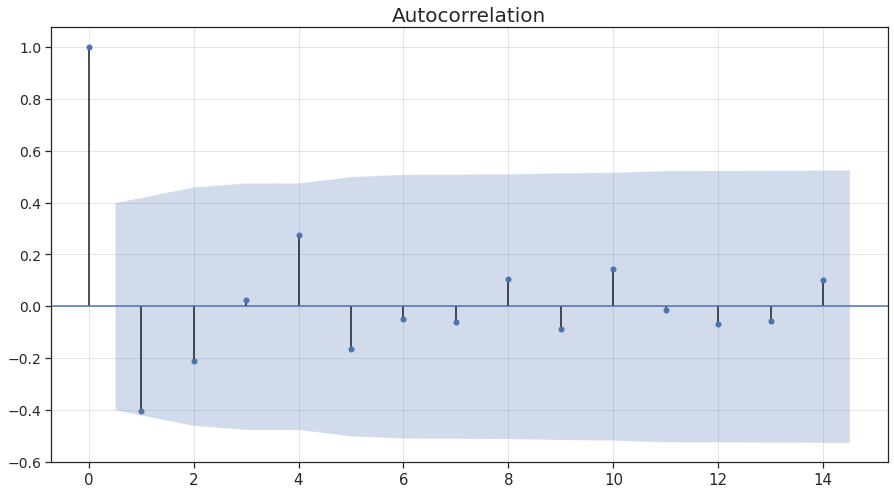

In [57]:
plot_acf(regression1.resid);

In [61]:
_kf = acf(regression1.resid, fft=False)[1]
t = (((_kf**2) * (regression1.resid.size-2)) / (1-_kf**2))**.5
t

2.0755560420272494

In [60]:
#Смотрим на зону, в которую попадает это число. (Если меньше примерно 1.5, то положительная автокорреляция)
durbin_watson(regression1.resid)

2.779193745409364